# Using Fixed Effects Models for Meta-Analysis
April 2020, [J. Nathan Matias](https://natematias.com)

This jupyter notebook builds on the lecture on [asking questions with the Upworthy Archive](https://github.com/natematias/design-governance-experiments/blob/master/lectures/Lecture%2015%20-%20Asking%20Questions%20of%20the%20Upworthy%20Archive.pdf). The lecture ended with an illustration of the estimate and upper/lower confidence intervals for a large number of A/B tests. 

This notebook introduces basic concepts in meta-analysis and shows how to analyze the a collection of tests from the Upworthy Archive. We will continue investigating the effect of including notable people's names in headlines on the chance of someone clicking on an article.

![multiple experiment results](images/multiple-experiments.png)



# What is Meta-Analysis?

Meta-analysis is the area of statistics concerned with combining the results of multiple studies:
* to find out if an effect can be replicated
* to study other patterns in effects, such as the conditions/contexts in which a given effect occurs

In typical meta-analysis, researchers:
* develop a method to search for published and un-published results
* record the statistical results (or even better, original data) for each study they find
* think about and account for the "file drawer" of studies that weren't shared because they weren't statistically-significant
* develop a final statistical test that asks their question from the full table of published, unpublished, and inferred results

With the Upworthy archive, we have several advantages:
* we know about every A/B test that was conducted, so there's no "file drawer" problem
* the outcome variable is the same for every study
* the intervention for every study is similar in nature


# Table of Contents
This notebook covers the following topics:
* an introduction to between-group and within-group variation
* fixed effects models
* an example of using fixed effects models for meta-analysis

# Load Libraries and Data

In [2]:
library(ggplot2)   # for charts
library(stringr)   # for text matching
library(gmodels)   # for CrossTable
library(ngram)     # for word counts
library(corrplot)  # correlation plot
library(gridExtra) # combining plots
library(plm)       # fixed effects models
library(lme4)      # random effects models
library(lmerTest)  # significance esting for lme4

set.seed(1868)  # setting random seed to the year Cornell opened
options(repr.plot.width=7, repr.plot.height=3) #set figure size


class.theme <- theme_bw() +
               theme(plot.title = element_text(size = 13, face = "bold"),
                     axis.title.x = element_text(size = 8, hjust = -0.01,
                                                 color = "#333333"))

#### Load Packages from the Upworthy Archive
An explanation of the relevant fields can be found in the slides on [asking questions with the Upworthy Archive](https://github.com/natematias/design-governance-experiments/blob/master/lectures/Lecture%2015%20-%20Asking%20Questions%20of%20the%20Upworthy%20Archive.pdf).

In [2]:
packages.df <- read.csv("upworthy-archive-exploratory-packages-03.12.2020.csv")
packages.df$headline <- tolower(packages.df$headline)
packages.df$created <- as.POSIXct(packages.df$created_at)

earliest.date <- min(packages.df$created)
packages.df$week.age <- as.integer(difftime(packages.df$created, earliest.date, unit="weeks"))
packages.df$weekday <- factor(weekdays(packages.df$created))
## Retain only columns used in this analysis
packages.df <- packages.df[c("clickability_test_id", "impressions", "clicks", "headline","week.age", "weekday")]

#### Create Outcomes and Covariates For Analysis
A "covariate" is a variable (or column) that might be predictive of an outcome we care about - in this case the click-through rate.

These covariates are only for the purpose of illustrating statistical concepts. For a scientifically-valid study, you would want to use variables that have been carefully crafted and thoroughly validated.

In [3]:
### Outcome Variable: proportion of clicks
packages.df$click.rate <- packages.df$clicks / packages.df$impressions

#### Create Covariates
# # Whether a headline includes a superlative or not
# packages.df$superlative.words <- as.numeric(str_count(packages.df$headline, 
#                                       "est |worst|most|better|least|blow your"))

# Whether a headline includes a question mark
packages.df$question <- as.numeric(str_detect(packages.df$headline, "\\?"))

# # Whether a headline includes a pronoun, demonstrative, or other reference word
# packages.df$reference.words <- as.numeric(str_count(packages.df$headline, 
#                                          "^a |them|they|their|this|these|those|that"))

# # The number of words in the headline
# packages.df$headline.wordcount <- apply(packages.df[c("headline")], 1,  FUN=wordcount)

#### Summary Statistics for Outcome and Covariates

In [4]:
summarize.column <- function(df, colname){
    summary(df[colname])
}

summarize.column(packages.df, "click.rate")

# summarize.column(packages.df, "superlative.words")
summarize.column(packages.df, "question")
# summarize.column(packages.df, "reference.words")
# summarize.column(packages.df, "headline.wordcount")
summarize.column(packages.df, "weekday")

   click.rate      
 Min.   :0.000000  
 1st Qu.:0.007463  
 Median :0.012537  
 Mean   :0.015754  
 3rd Qu.:0.020281  
 Max.   :0.136063  

    question    
 Min.   :0.000  
 1st Qu.:0.000  
 Median :0.000  
 Mean   :0.156  
 3rd Qu.:0.000  
 Max.   :1.000  

      weekday    
 Friday   :3983  
 Monday   :3336  
 Saturday :1217  
 Sunday   :1029  
 Thursday :4421  
 Tuesday  :4134  
 Wednesday:4546  

### Generate and Merge Test Level Variables to the Packages Dataframe

In the Upworthy archive, some covariates (such as the week or weekday of a test) are about tests rather than individual packages. The following code "aggregates" test-level means for several variables and records test-specific variables.

In [5]:
## Generate test-level variables and merge them back onto the packages dataframe

test.means.df <- aggregate(
    packages.df[c("clicks",
                  "impressions",
                  "click.rate",
                   "question",
#                   "headline.wordcount",
#                   "reference.words",
#                   "superlative.words", 
                  "week.age")], by=list(packages.df$clickability_test_id), FUN=mean)

colnames(test.means.df) <- c(
    "clickability_test_id",
    "test.clicks.mean",
    "test.impressions.mean",
    "test.click.rate.mean",
     "test.question.mean",
#     "test.headline.wordcount.mean",
#     "test.reference.words.mean",
#     "test.superlative.words.mean",
    "test.week.age")

## Add the weekday of the test to the test dataframe
test.weekday.df <- aggregate(packages.df[c("weekday", "week.age")], list(packages.df$clickability_test_id), FUN=head, 1)
colnames(test.weekday.df) <- c("clickability_test_id", "weekday", "week.age")

test.means.df <- merge(test.means.df, test.weekday.df, by="clickability_test_id")
test.means.df$weekday <- factor(test.means.df$weekday)
test.means.df <- within(test.means.df, weekday <- relevel(weekday, ref=1))

## Merge test-level variables to the packages dataframe
packages.df <- merge(packages.df, test.means.df, by="clickability_test_id")

# Why You Can't Just Use a Single Statistical Model: Between-Group Variation and Within-Group Variation

Once you have all of the observations from all of the experiments, why can't you just conduct a single linar regression or t-test to see if the intervention has an effect? There are a several reasons:

* each test has a different sample size
* you might mistakenly detect **differences in outcomes between tests** and consider them to be **differences between arms within tests**

How can we think about "between-group" variation and "within-group" variation? In statistics, whenever a set of observations is grouped in some way, we need to use some form of **multilevel** modeling. Examples include:
* students within classes within schools
* athletes within teams
* products within manufacturers

For example, we know the performance of a single football player is not purely due to individual ability- it depends on the captain, the coach, and the resources available to the team. Players often perform very differently when they move to a new team because the team matters.

The same is true for headlines in the Upworthy Archive. The same headline might receive more clicks on Monday than Friday. Or the same rhetorical approach (naming a notable person) might perform differently one year compared to the next.

The "caterpiller plots" below illustrate the difference between within-group variation and between-group variation.

In [6]:
## Select N sample tests for illustrating within group varation
## and between group variation, and then plot the caterpillar plot
sample.size = 100

test.subsample.df <- test.means.df[sample(nrow(test.means.df), sample.size), ]
packages.subsample.df <- subset(packages.df, clickability_test_id %in% test.subsample.df$clickability_test_id)

### Box plot / caterpillar plot
The caterpiller plot below on the left shows the mean click through rate and confidence intervals for 100 tests in the exploratory sample. The plot on the right is a "de-meaned" caterpiller plot. 

To produce the de-meaned plot, I subtracted the click rate for each individual experiment arm from the average click rate across the whole test. That achieves three things: 
* the distribution of each test is centered on zero
* the average click rate for each test is now the same for every test
* with all between-test variation removed, the only variation remaining is the variation between arms

*The ideas behind [the boxplot](https://en.wikipedia.org/wiki/Box_plot) were developed by [Mary Spear (1897-1986)](https://en.wikipedia.org/wiki/Mary_Eleanor_Spear) and [John Tukey (1915-2000)](https://en.wikipedia.org/wiki/John_Tukey)*. 

Boxplots typically report the median, while caterpillar plots report the mean. That's why I wrote some custom code and use *stat_summary* to illustrate results rather than *geom_boxplot*.

In [7]:
## reset figure size
options(repr.plot.width=5, repr.plot.height=7)

# function for computing mean, DS, max and min values
# we do this because the default boxplot graphic
# illustrates the median rather than the mean
min.mean.sd.max <- function(x) {
  r <- c(min(x), mean(x) - sd(x), mean(x), mean(x) + sd(x), max(x))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

## show a boxplot, re-ordered by mean
p.means <- ggplot(packages.subsample.df,
               aes(click.rate, 
                   reorder(clickability_test_id, click.rate, FUN=mean))) +
            stat_summary(fun.data=min.mean.sd.max,
                         geom="boxplot",
                         size=0.3) +
            class.theme +
            theme(axis.text.y = element_text(size = 4.5, hjust = -0.01,
                                              color = "#333333")) +
            ylab("Test ID") +
            ggtitle(paste("Between test variation\n(n= ",sample.size," tests)", sep=""))

In [8]:
## create a "de-meaned" outcome that makes it possible to show differences within tests
packages.subsample.df$click.rate.demeaned <-
    packages.subsample.df$click.rate - packages.subsample.df$test.click.rate.mean

## show a boxplot, re-ordered by mean
p.demeaned <- ggplot(packages.subsample.df,
                   aes(click.rate.demeaned, 
                       reorder(clickability_test_id, click.rate, FUN=mean))) +
                stat_summary(fun.data=min.mean.sd.max,
                             geom="boxplot",
                             size=0.3, color="#aa3300") +
                class.theme +
                theme(axis.text.y = element_blank(),
                      plot.title = element_text(color="#aa3300")) +
                ylab("") +
                ggtitle(paste("Within test variation\n(de-meaned)", sep=""))

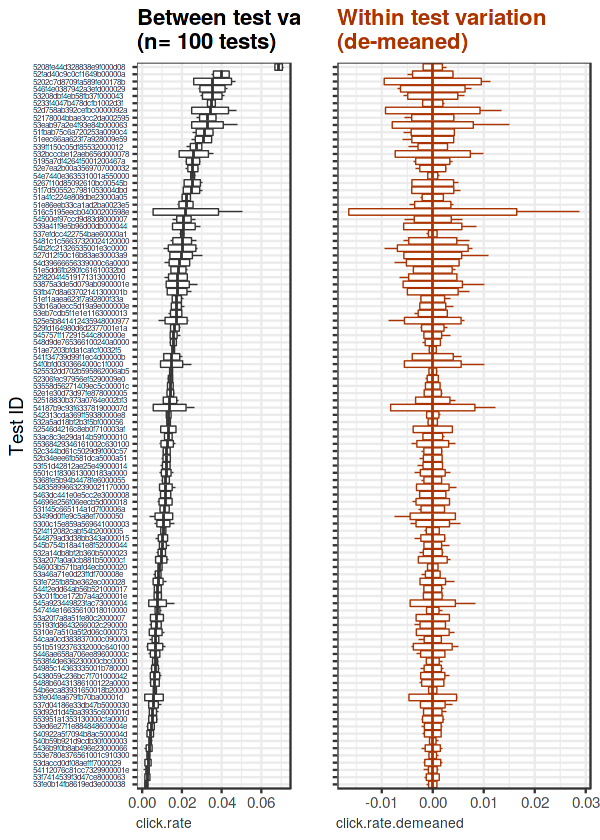

In [9]:
## PLOT BOTH SIDE BY SIDE
grid.arrange(p.means, p.demeaned, ncol=2)

### How Between-Test Variation Could Bias Our Meta-Analysis
Imagine that a headline in the test at the top of this chart were compared to a headline in the test at the bottom of the chart. Next, imagine hypothetically that the second headline is actually more influential than the first.

In this imaginary scenario, the second (more influential) headline is linking to a very unpopular story, while the first (less influential) headline is about a very popular story. If you were compare them directly, you might wrongly believe that the less effective headline was actually more effective. That's a serious source of bias, and it's why we worry about between-group variation.

Since our goal is to study effects within tests, and since some tests are intrinsically more clicked than others, we need a way to put all of the tests on the same scale. De-meaning is one way to do that. Fixed effects models are another.

# Fixed Effects Models
Fixed effects models offer one way to account for between-group variation in statistics. Like de-meaning, fixed effects models try to account for between-group variation and focus on accurately estimating within-group variation. So if you have a question about differences between groups, fixed effects models can't help.

Under the hood, fixed effects models do something very similar to fitting a multivariate regression model a categorical predictor for the test ID (*join the statistics workshop if you need a refresher on multiple regression*). The predictors for each test account for group-level variation, improving the precision of the estimate of the treatment effect within tests.

In the following example, I compare headlines that include a question mark to headlines that don't include a question mark:
* first with a single-predictor linear regression model, where between-test variation is too great and we fail to reject the null hypothesis
* second with a multiple linear regression model which uses the test ID as a predictor, and where the estimate is different from the first model and statistically-significant
* thirdly with a fixed effects model, whose results are identical to the multiple regression

You can learn more about fixed effects models in the following book:

* Singer, J. D., Willett, J. B., & Willett, J. B. (2003). [Applied longitudinal data analysis: Modeling change and event occurrence](https://www.oxfordscholarship.com/view/10.1093/acprof:oso/9780195152968.001.0001/acprof-9780195152968). Oxford university press.

For this notebook, know that the fixed effects model produces equivalent results to a multi-variate regression where each of the groups (test IDs) is a binary predictor in the model (see examples below). Here is the formula for a fixed effects model.

$$y_{ij} = \beta_{0} + \beta_{1}X_{ij} + \mathbf{u_{j}} + \epsilon_{ij }$$ 

For the test of the effect of using a question mark in a headline, the model looks like this:

$$CLICK.RATE_{ij} = \beta_{0} + \beta_{1}QUESTION_{ij} + u_{j} + \epsilon_{ij }$$ 

... where $u_j$ refers to the residuals/error associated with the test.


Mathematically, you will notice that it differs from a linear regression formula in several ways:
* predictions are for *ij*, an individual within a group
* it includes:
  * $u_j$:  an error/residuals term for groups
  * $\epsilon_{ij }$: an error/residuals term for individuals


In [10]:
summary(lm(click.rate ~ question, data=packages.subsample.df))


Call:
lm(formula = click.rate ~ question, data = packages.subsample.df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.014274 -0.007341 -0.002041  0.004883  0.056163 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.015188   0.000541  28.073   <2e-16 ***
question    -0.001852   0.001350  -1.372    0.171    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01071 on 465 degrees of freedom
Multiple R-squared:  0.00403,	Adjusted R-squared:  0.001888 
F-statistic: 1.882 on 1 and 465 DF,  p-value: 0.1708


In [11]:
lm.test.categorical <- lm(click.rate ~ question + clickability_test_id, data=packages.subsample.df)
lm.test.categorical.coef <- coef(summary(lm.test.categorical))
lm.test.categorical.coef[c("(Intercept)", "question"),]

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.022649721,0.0017968176,12.605465,1.659855e-30
question,-0.001701737,0.0008067755,-2.109307,3.559677e-02


In [12]:
summary(plm(click.rate ~ question,
            index="clickability_test_id",
            model="within",
            data=packages.subsample.df))

Oneway (individual) effect Within Model

Call:
plm(formula = click.rate ~ question, data = packages.subsample.df, 
    model = "within", index = "clickability_test_id")

Unbalanced Panel: n = 100, T = 2-11, N = 467

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-0.01050412 -0.00180374 -0.00012501  0.00162732  0.02806549 

Coefficients:
            Estimate  Std. Error t-value Pr(>|t|)  
question -0.00170174  0.00080678 -2.1093   0.0356 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    0.0057872
Residual Sum of Squares: 0.0057177
R-Squared:      0.01201
Adj. R-Squared: -0.25793
F-statistic: 4.44917 on 1 and 366 DF, p-value: 0.035597

# Using a Fixed Effects Model for Meta Analysis

In the above example, I worked with the full dataset so the variation between tests would be clearer. But it's important to carefully select a subset of tests, As discussed in the [Upworthy archive slides](https://github.com/natematias/design-governance-experiments/blob/master/lectures/Lecture%2015%20-%20Asking%20Questions%20of%20the%20Upworthy%20Archive.pdf) and the [code for selecting valid tests](https://github.com/natematias/design-governance-experiments/blob/master/assignments/upworthy-archive-project/selecting_upworthy_archive_packages.py.ipynb).

In the following example, I use a fixed effects model to estimate the effect (if any) of naming a notable person on the chance of someone clicking on the headline/image package.

In [13]:
participant.df <- read.csv("upworthy_archive_exploratory_max_effect_size_dataset.csv")
print(paste(length(unique(participant.df$clickability_test_id)), "tests"))
print(paste(length(unique(participant.df$headline_index)), "packages"))
print(paste(nrow(participant.df), "total participants"))
colnames(participant.df)

[1] "40 tests"
[1] "80 packages"
[1] "270177 total participants"


[1] "clickability_test_id" "headline_index"       "has_treatment"       
[4] "clicked"

## Result With a Linear Regression Model

In [14]:
summary(lm(clicked ~ has_treatment, data=participant.df))


Call:
lm(formula = clicked ~ has_treatment, data = participant.df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.01865 -0.01865 -0.01497 -0.01497  0.98503 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.0149664  0.0003505  42.704  < 2e-16 ***
has_treatment 0.0036828  0.0004947   7.445 9.75e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1286 on 270175 degrees of freedom
Multiple R-squared:  0.0002051,	Adjusted R-squared:  0.0002014 
F-statistic: 55.42 on 1 and 270175 DF,  p-value: 9.746e-14


## Result with a Fixed Effects Model

In [15]:
summary(plm(clicked ~ has_treatment,
            index="clickability_test_id",
            model="within",
            data=participant.df))

Oneway (individual) effect Within Model

Call:
plm(formula = clicked ~ has_treatment, data = participant.df, 
    model = "within", index = "clickability_test_id")

Unbalanced Panel: n = 40, T = 2025-20505, N = 270177

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-0.0708440 -0.0182503 -0.0121964 -0.0074033  0.9976035 

Coefficients:
               Estimate Std. Error t-value  Pr(>|t|)    
has_treatment 0.0033261  0.0004914  6.7685 1.304e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    4404.5
Residual Sum of Squares: 4403.8
R-Squared:      0.00016956
Adj. R-Squared: 2.1512e-05
F-statistic: 45.8122 on 1 and 270136 DF, p-value: 1.3042e-11

# Bonus Round: Testing Hypotheses about Group Differences with a Random Intercepts Model
With a fixed effects model, you can't include predictors/covariates that are characteristics of the group. Random intercepts models (which have fairly different mathematics & algorithms) allow you to make predictions about both individuals and groups.

Because they are maximum likelihood models, it can take substantial effort to get these models right. I include this example purely so you are aware of the general approach. If you are interested, you can also learn more about multi-level models in the following book:

* Singer, J. D., Willett, J. B., & Willett, J. B. (2003). [Applied longitudinal data analysis: Modeling change and event occurrence](https://www.oxfordscholarship.com/view/10.1093/acprof:oso/9780195152968.001.0001/acprof-9780195152968). Oxford university press.

## Group Level Variables

So far, we have considered variables at the level of individual arms of the experiment (packages). But we know that there are characteristics of a test overall that are related to how likely someone is to click. One example is the weekday that a test was conducted (*weekday*). Another is the number of weeks since the first test(*week.age*).

If the test was conducted on a day of the week when people are less likely to click (maybe they're working on enjoying the weekend) then we would expect the click rate to be lower even for a highly influential headline. Similarly, if people were clicking less on Upworthy links as time went on, we would expect week.age to predict differences between tests. That's what the following model tests.

In [16]:
## merge weekday and week age onto participant.df
participant.df <- merge(participant.df,
                     test.weekday.df,
                     by="clickability_test_id", all.x=TRUE)

In [17]:
head(participant.df)

,clickability_test_id,headline_index,has_treatment,clicked,weekday,week.age
,<fct>,<int>,<int>,<int>,<fct>,<int>
1,5143608e220cb800020009ed,3708,1,1,Saturday,0
2,5143608e220cb800020009ed,3708,1,1,Saturday,0
3,5143608e220cb800020009ed,3708,1,1,Saturday,0
4,5143608e220cb800020009ed,3708,1,1,Saturday,0
5,5143608e220cb800020009ed,3708,1,1,Saturday,0
6,5143608e220cb800020009ed,3708,1,1,Saturday,0


In [18]:
# This model tests the hypothesis that has_treatment has an effect
# and that the effect changes over time with the week age.
# In this case, we fail to reject the null hypothesis that any
# differences in the average treatment effect are due to random chance

summary(ri.clicked.notable <-
        lmer(clicked ~ has_treatment + week.age + has_treatment:week.age + (1|clickability_test_id), 
             data=participant.df))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: clicked ~ has_treatment + week.age + has_treatment:week.age +  
    (1 | clickability_test_id)
   Data: participant.df

REML criterion at convergence: -345227.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.5446 -0.1431 -0.0974 -0.0606  7.8137 

Random effects:
 Groups               Name        Variance  Std.Dev.
 clickability_test_id (Intercept) 0.0001459 0.01208 
 Residual                         0.0163019 0.12768 
Number of obs: 270177, groups:  clickability_test_id, 40

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             4.187e-02  5.690e-03  4.012e+01   7.359 5.86e-09 ***
has_treatment           1.221e-03  1.526e-03  2.701e+05   0.800    0.424    
week.age               -3.383e-04  6.875e-05  4.016e+01  -4.920 1.52e-05 ***
has_treatment:week.age  2.747e-05  1.884e-05  2.701e+05   1.458    0.145    
---
Sign

# LICENSE 

 Copyright 2020 J. Nathan Matias.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.